In [1443]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

rapids-0.19


In [4]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

# Import aligned data

In [5]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data

In [6]:
from pathlib import Path

dir_S2p                  = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

dir_ROIClassifier        = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight')

dir_ws                   = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws              = Path(r'exp_0001.h5')

dir_behaviorSignals      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_behaviorSignals = Path(r'signals_S2pAligned.npy')
# fileName_behaviorSignals = Path(r'alignment_data.npy')

In [7]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(dir_ws / fileName_ws)

behaviorSignals = np.load(dir_behaviorSignals / fileName_behaviorSignals , allow_pickle=True)[()]
# this line of code is reckless but useful. It imports all of the key-value pairs in a dict as variables
locals().update(behaviorSignals)
print(f'== VARIABLES imported from "behaviorSignals" ==')
for key, value in behaviorSignals.items():
    print(key)

== VARIABLES imported from "behaviorSignals" ==
ws_licks_bool_S2pInd
ws_rewards_bool_S2pInd
ws_treadmill_S2pInd
camSignal_s2pInd


# Preprocess signals

In [233]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import welford_moving_2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### preprocess Fluorescence data
these functions isn't necessary yet and can be slower on large data

In [221]:
dFoF,_,_,_ = timeSeries.make_dFoF(F=F.T,
                                                Fneu=Fneu.T,
                                                neuropil_fraction=0.7,
                                                percentile_baseline=30,
                                                multicore_pref=True,
                                                verbose=True)

F_zscore = timeSeries.zscore_multicore(dFoF,
                                                     verbose=True)

Fs = ops[()]['fs']
win_roll = round(Fs * 60 * 10)
F_zscore_roll = welford_moving_2D.make_rollingZScore(dFoF,
                                                     win_roll)

ThreadPool elapsed time : 2.19 s. Now unpacking list into array.
Calculated dFoF. Total elapsed time: 3.92 seconds
ThreadPool elapsed time : 1.62 s. Now unpacking list into array.
Calculated zscores. Total elapsed time: 2.53 seconds


100%|██████████| 108000/108000 [01:08<00:00, 1580.86it/s]
/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


### preprocess spiking data

<IPython.core.display.Javascript object>


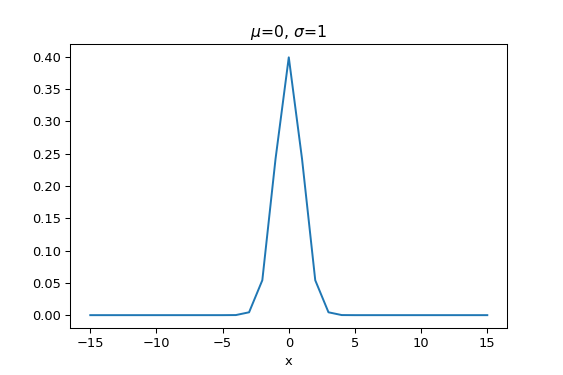

ThreadPool elapsed time : 0.73 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 1.64 seconds


In [580]:
gaussian_kernel , params_gaus = timeSeries.gaussian(x=np.arange(-15,16,1),
                                                                  mu=0,
                                                                  sig=1,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks.T,
                                                         gaussian_kernel,
                                                         axis=0,
                                                         mode='same',
                                                         multicore_pref=True,
                                                         verbose=True)
neural_data = spks_conv[:,IsCell_ROIClassifier==True]

# data exploration

visualize face rhythms output timeseries for regression

In [581]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


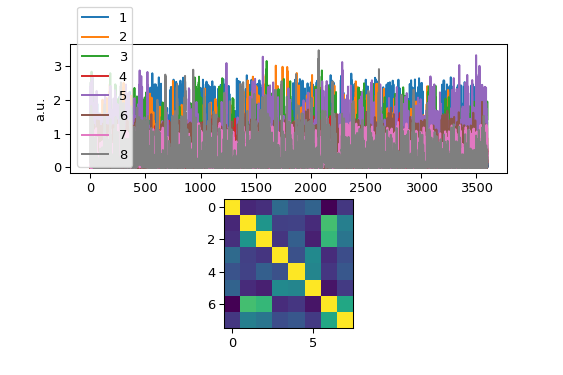

In [582]:
%matplotlib notebook

## just for plotting 
Fs = ops[()]['fs']

fig , axs = plt.subplots(2)
axs[0].plot(np.arange(camSignal_s2pInd.shape[0])/Fs, camSignal_s2pInd);
axs[0].legend(np.arange(camSignal_s2pInd.shape[1])+1)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('a.u.')

axs[1].imshow(decomposition.make_xcorrMat(camSignal_s2pInd));

### Do PCA

first run PCA on the inputs and outputs to orthogonalize them


look at scree plots and timeSeries of PCs

<IPython.core.display.Javascript object>


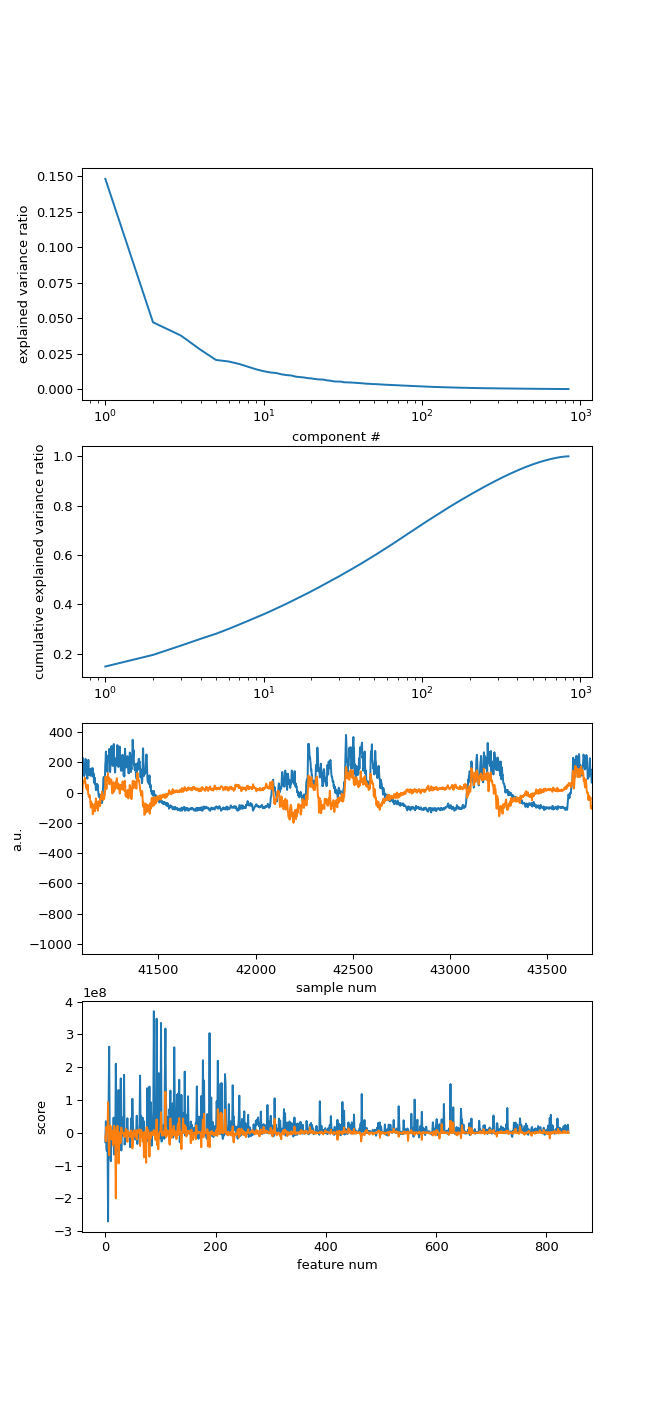

<IPython.core.display.Javascript object>


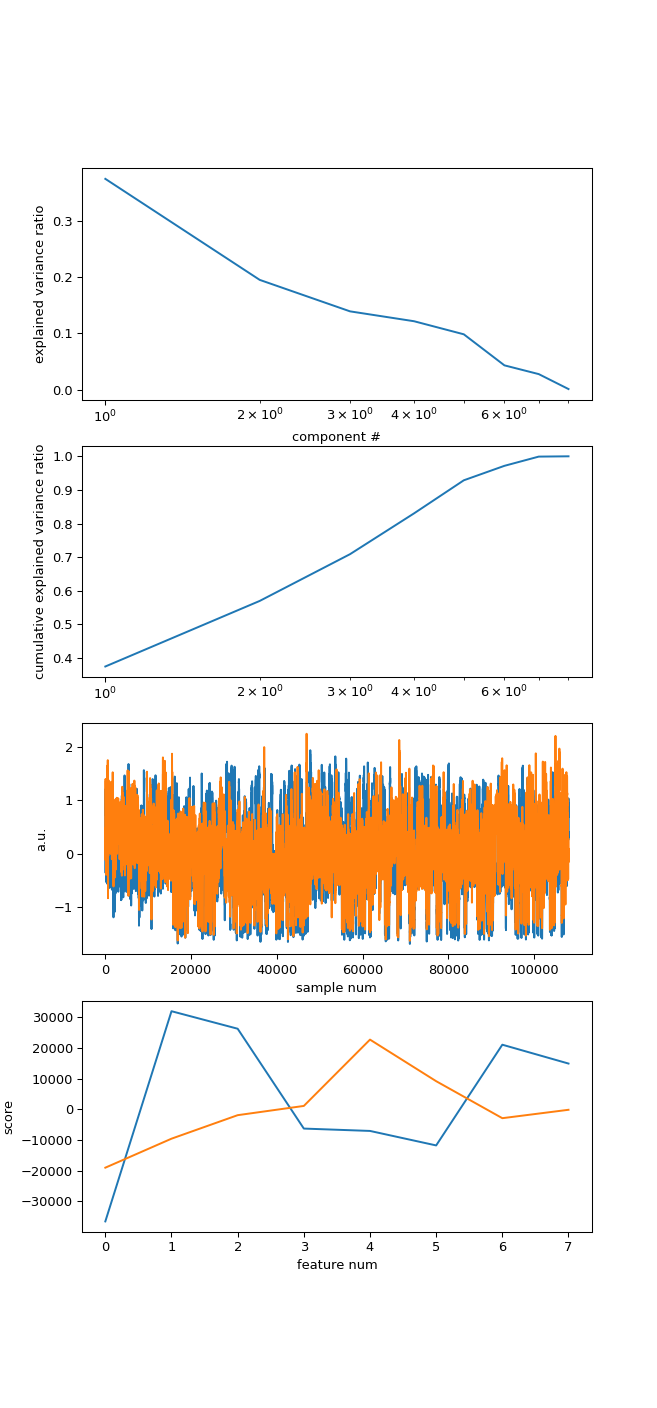

In [583]:
PCA_outputs_neural_temporalFactor , PCA_outputs_neural_neuronFactor , EV_ratio_neural = decomposition.simple_pca(neural_data,
                                                                                               n_components=neural_data.shape[1],
                                                                                               plot_pref=True)

PCA_outputs_behavioral , PCA_outputs_behavioral_componentFactor , EV_ratio_behavioral = decomposition.simple_pca(camSignal_s2pInd,
                                                                                           n_components=camSignal_s2pInd.shape[1],
                                                                                           plot_pref=True)

### Run Rastermap

In [670]:
import rastermap.mapping

# X = copy.deepcopy(neural_data[:,:].T)
# X = copy.deepcopy(spks)
X = scipy.stats.zscore(spks_conv[:,iscell[:,0]==1].T , axis=0)

{'n_components': 1, 'n_X': 100, 'alpha': 1., 'K': 1.,
                    'nPC': 200, 'constraints': 2, 'annealing': True, 'init': 'pca',
                    'start_time': 0, 'end_time': -1}
decomp = rastermap.mapping.Rastermap(n_components=1,
                             n_X=300,
                             nPC=400,
                             init='pca',
                             alpha=1.0,
                             K=1.0,
                             mode='basic',
                             verbose=True,
                             annealing=True,
                             constraints=2,)
embedding = decomp.fit_transform(X)

nmin 400
0.8365833759307861
22.015357494354248
23.13678288459778
23.151825428009033
(298, 300)
(154,)
1.0
time; iteration;  explained PC variance
0.02s     0        0.1663      2
0.34s    10        0.2500      7
0.75s    20        0.3119      17
1.18s    30        0.3828      42
1.69s    40        0.4408      67
2.04s    50        0.4822      92
2.32s    60        0.5121      117
2.59s    70        0.5367      142
2.87s    80        0.5607      167
3.16s    90        0.5796      192
3.49s    100        0.5971      217
3.82s    110        0.6149      242
4.11s    120        0.6330      267
4.39s    130        0.6506      292
4.70s    140        0.6551      298
5.00s    150        0.6551      298
5.08s   final      0.6551
5.09s upsampled    0.6551


In [673]:
X_crop = timeSeries.threshold(X,
                            thresh_max=3,
                            val_max=None
                             )

%matplotlib notebook
plt.figure()
plt.imshow(X_crop[decomp.isort , :] , aspect='auto')

In [15]:
# compare NMF(neural data) to FR(behavioral data)_temporal factors



In [23]:
manual_selection_vars = np.load('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight/manual_selection_vars.npy' , allow_pickle=True)

In [27]:
manual_selection_vars[()].keys()

dict_keys(['toInclude_preExclusion', 'toExclude_manuallyClicked', 'predictions', 'output_activations', 'prob', 'toInclude_final', 'spatial_footprints_centered_toInclude', 'spatial_footprints_centered_crop_toInclude'])

In [31]:
IsCell_ROIClassifier2 = np.zeros(len(IsCell_ROIClassifier)+1)
IsCell_ROIClassifier2[:len(IsCell_ROIClassifier)] = IsCell_ROIClassifier
IsCell_ROIClassifier2.shape

(4870,)

In [32]:
IsCell_ROIClassifier = copy.deepcopy(IsCell_ROIClassifier2)

In [93]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

# num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input /= np.std(X_input, axis=0)
# X_input = scipy.stats.zscore(X_input , axis=0)

# y_input = temporalFactors_s2pInd[:,:]

In [94]:
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
# y = copy.deepcopy(y_input)

<IPython.core.display.Javascript object>


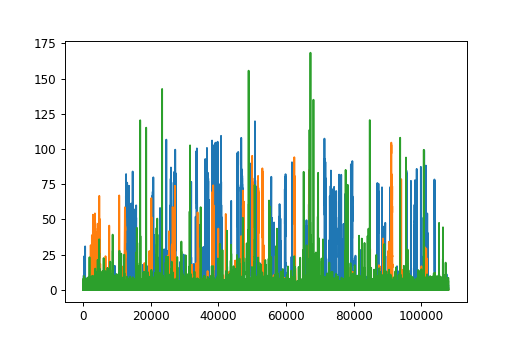

In [95]:
plt.figure()
plt.plot(X_input[:,np.array([0,1,800])])

In [191]:
fac_neuron2 = copy.deepcopy(fac_neuron)
fac_temp2 = copy.deepcopy(fac_temp)
rec_err2 = copy.deepcopy(rec_err)

In [96]:
import tensorly as tl
import tensorly.decomposition
import torch

In [97]:
tl.set_backend('pytorch')
cuda_device_number = torch.cuda.current_device()
cuda_device_number
X_input_tensor = tl.tensor(X_input, dtype=tl.float32, device=0, requires_grad=False)

In [98]:
from tqdm.notebook import trange, tqdm
n_repeats = 1
# ranks = np.array([15,16,17,18,19,20,21,22])
# ranks = np.arange(30)+1
ranks = np.array([8])

n_ranks = len(ranks)
n_neurons = X_input.shape[1]
n_timepoints = X_input.shape[0]

fac_neuron = list(np.zeros(n_ranks))
fac_temp = list(np.zeros(n_ranks))
rec_err = list(np.zeros(n_ranks))
for i_rank, rank in enumerate(tqdm(ranks)):
    fac_neuron[i_rank] = np.zeros((n_neurons , rank , n_repeats))
    fac_temp[i_rank] = np.zeros((n_timepoints , rank , n_repeats))
    rec_err[i_rank] = np.zeros((n_repeats))
    for i_rep in trange(n_repeats):
        model = sklearn.decomposition.NMF(n_components=rank,
                                          init='random',
                                          solver='cd',
                                          beta_loss='frobenius',
                                          tol=0.000001,
                                          max_iter=10000,
                                          random_state=None,
                                          alpha=0.0,
                                          l1_ratio=0.0,
                                          verbose=False,
                                          shuffle=False,
                                          regularization='both'
                                         )

        fac_neuron[i_rank][:,:, i_rep] = model.fit_transform(X_input.T)
        fac_temp[i_rank][:,:, i_rep] = model.components_.T
        rec_err[i_rank][i_rep] = model.reconstruction_err_

#         k_tensor, recErr = tl.decomposition.non_negative_parafac_hals(
#                                                                         X_input_tensor,
#                                                                         rank,
#                                                                         n_iter_max=1000,
#                                                                         init='random',
#                                                                         svd='numpy_svd',
#                                                                         tol=1e-07,
#                                                                         sparsity_coefficients=None,
#                                                                         fixed_modes=None,
#                                                                         exact=False,
#                                                                         verbose=False,
#                                                                         return_errors=True,
#                                                                         cvg_criterion='abs_rec_error'
#                                                                         )
#
#         fac_neuron[i_rank][:,:, i_rep] = k_tensor[1][1].cpu()
#         fac_temp[i_rank][:,:, i_rep] = k_tensor[1][0].cpu()
#         rec_err[i_rank][i_rep] = recErr[-1].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
NMF_outputs = {
    "fac_neuron": fac_neuron,
    "fac_temp": fac_temp,
    "rec_err": rec_err,
    "ranks": ranks,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_save = 'NMF_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , NMF_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis/NMF_outputs20210504.npy


In [34]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'NMF_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

NMF_outputs = np.load(path_load , allow_pickle=True)

fac_neuron = NMF_outputs[()]['fac_neuron']
fac_temp = NMF_outputs[()]['fac_temp']
rec_err = NMF_outputs[()]['rec_err']
ranks = NMF_outputs[()]['ranks']

<IPython.core.display.Javascript object>


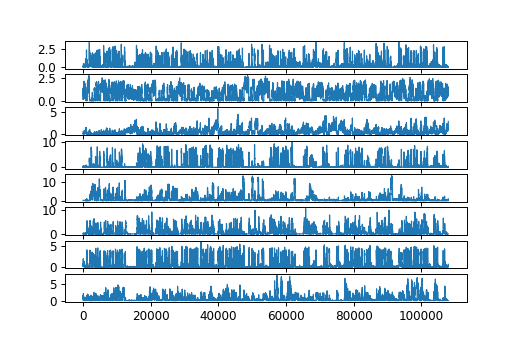

<IPython.core.display.Javascript object>


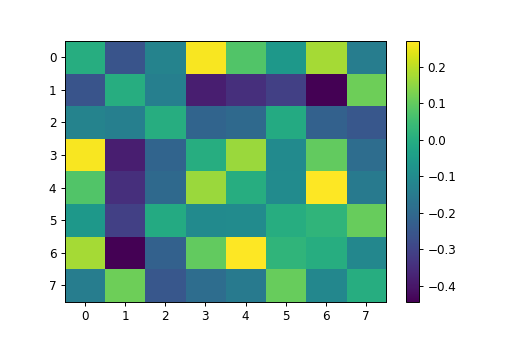

<IPython.core.display.Javascript object>


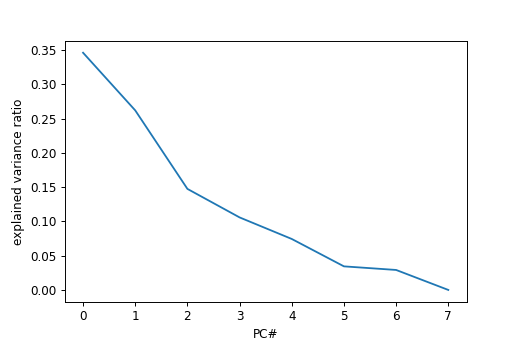

Text(0, 0.5, 'explained variance ratio')

In [101]:
%matplotlib notebook
repeat_toPlot = 0 # 0-indexed
rank_toPlot = 8 # 

rank_idx_toPlot = np.where(ranks==rank_toPlot)[0][0]
n_components = rank_toPlot
fig, axs = plt.subplots(n_components , sharex=True , sharey=False)
for ii in range(n_components):
    axs[ii].plot(fac_temp[rank_idx_toPlot][:,ii,repeat_toPlot] , linewidth=1)

plt.figure()
plt.imshow(np.corrcoef(fac_temp[rank_idx_toPlot][:,:,repeat_toPlot].T) - np.eye(n_components),aspect='auto')
plt.colorbar()

input_dimRed = fac_temp[rank_idx_toPlot][:,:,repeat_toPlot]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PC#')
plt.ylabel('explained variance ratio')

In [219]:
def pairwise_similarity(vector_set1 , vector_set2=None , method):
    '''
    computes similarity matrices between two sets of vectors (columns within 2-D arrays) using either pearson correlation, R^2, or cosine_similarity
    RH 2021

    Args:
        vector_set1 (ndarray): 2-D array of column vectors
        vector_set2 (ndarray): 2-D array of column vectors to compare to vector_set1. If None, then the function is a type of autosimilarity matrix
    Returns:
        ouput (ndarray): similarity matrix
    '''
    from numpy.linalg import norm
    from scipy.stats import zscore
    
    if vector_set2 is None:
        vector_set2 = vector_set1
        
    if method=='pearson':
        output = (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2)
    if method=='R^2':
        output = ( (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2) )**2
    if method=='cosine_similarity':    
        output = (vector_set1 / (np.expand_dims(norm(vector_set1 , axis=0) , axis=0))).T  @ (vector_set2  / np.expand_dims(norm(vector_set2 , axis=0) , axis=0))
    return output

def similarity_2(mat1 , mat2 , method):
    import numpy as np
    '''
    This function compares the representations of two sets of vectors (columns of mat1 and columns of mat2).
    We assume that the vectors in mat1 and mat2 are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors
    RH 2021
    
    Args:
        mat1 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat2
        mat2 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat1
        method (string)  : defines method of calculating pairwise similarity between vectors
        
    Returns:
        sim_avg (double)    : the average similarity between matched vectors. Units depend on method
        sim_matched (double): the similarity between each pair of matched vectors.
        ind1 (int)          : indices of vectors in mat1 matched to ind2 in mat2 (usually just sequential for ind1)
        ind2 (int)          : indices of vectors in mat2 matched to ind1 in mat1
    '''
    corr = mat1.T @ mat2
    ind1 , ind2 = scipy.optimize.linear_sum_assignment(corr, maximize=True)
    sim_matched = np.zeros(len(ind1))
    for ii in range(len(ind1)):
        if method=='pearson':
            sim_matched[ii] = np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1]
        if method=='R^2':
            sim_matched[ii] = (np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1])**2
        if method=='cosine_similarity':
            sim_matched[ii] = pairwise_similarity( mat1[:,ind1[ii]] , mat2[:,ind2[ii]] , 'cosine_similarity')

    sim_avg = np.mean(sim_matched)
    return sim_avg , sim_matched , ind1 , ind2

def self_similarity_pairwise(mat_set , method):
    '''
    This function compares sets of 2-D matrices within a 3-D array using the similarity_2 function.
    We assume that the vectors within the matrices are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors within each matrix
    RH 2021
    
    Args:
        mat_set (np.ndarray): a 3D array where the columns within the first two dims are vectors we wish to match with the columns from matrices from other slices in the third dimension
        method (string)     : defines method of calculating pairwise similarity between vectors

    Returns:
        same as similarity_2, but over each combo
        combos: combinations of pairwise comparisons
    '''
    
    import itertools

    n_repeats = mat_set.shape[2]
    n_components = mat_set.shape[1]

    combos = np.array(list(itertools.combinations(np.arange(n_repeats),2)))
    n_combos = len(combos)

    corr_avg = np.zeros((n_combos))
    corr_matched = np.zeros((n_components , n_combos))
    ind1 = np.zeros((n_components , n_combos))
    ind2 = np.zeros((n_components , n_combos))
    for i_combo , combo in enumerate(combos):
        corr_avg[i_combo] , corr_matched[:,i_combo] , ind1[:,i_combo] , ind2[:,i_combo]  =  similarity_2(mat_set[:,:,combo[0]]  ,  mat_set[:,:,combo[1]] , method)
    # print(corr_avg)
    return corr_avg, corr_matched, ind1, ind2, combos

In [ ]:
n_ranks = len(ranks)

corr_avg = list(np.zeros(n_ranks))
corr_matched = list(np.zeros(n_ranks))
ind1 = list(np.zeros(n_ranks))
ind2 = list(np.zeros(n_ranks))
combos = list(np.zeros(n_ranks))
corr_avg_mean = np.zeros(n_ranks)
corr_avg_std = np.zeros(n_ranks)


for i_rank, rank in enumerate(tqdm(ranks)):
    corr_avg[i_rank], corr_matched[i_rank], ind1[i_rank], ind2[i_rank], combos[i_rank] = self_similarity_pairwise(fac_temp[i_rank] , 'pearson')
    corr_avg_mean[i_rank] = np.mean(corr_avg[i_rank])
    corr_avg_std[i_rank] = np.std(corr_avg[i_rank])
    

In [64]:
rec_err_mean = np.zeros(n_ranks)
rec_err_std = np.zeros(n_ranks)
for i_rank, rank in enumerate(ranks):
    rec_err_mean[i_rank] = np.mean(rec_err[i_rank])
    rec_err_std[i_rank] = np.std(rec_err[i_rank])

<IPython.core.display.Javascript object>


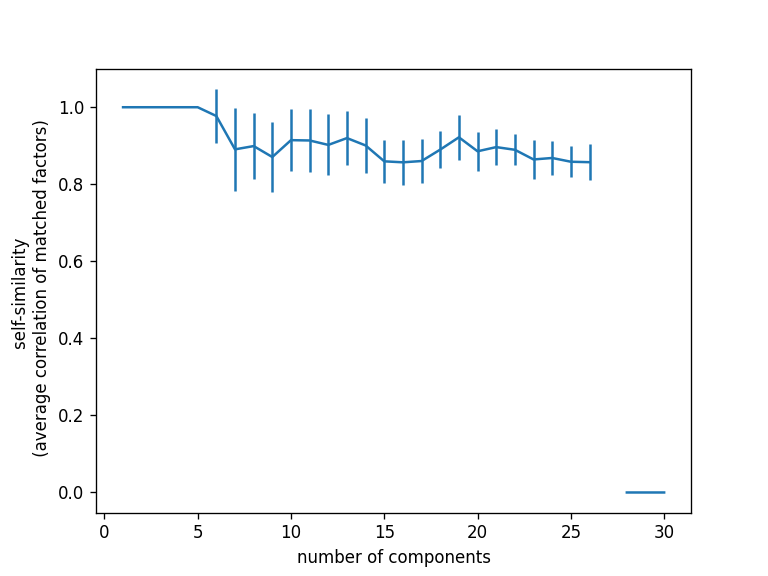

<IPython.core.display.Javascript object>


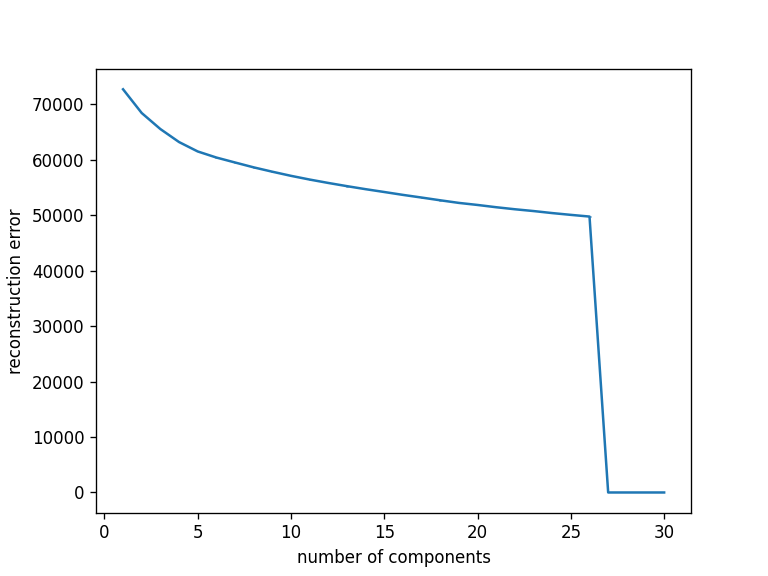

Text(0, 0.5, 'reconstruction error')

In [65]:
plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1,
             corr_avg_mean,
             yerr=corr_avg_std
            )
plt.xlabel('number of components')
plt.ylabel('self-similarity \n (average correlation of matched factors)')

plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1, rec_err_mean, yerr=rec_err_std)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [66]:
all_comparisons = {
    "corr_avg": corr_avg,
    "corr_matched": corr_matched,
    "ind1": ind1,
    "ind2": ind2,
    "combos": combos,
}
summary_stats = {
    "rec_err_mean": rec_err_mean,
    "rec_err_std": rec_err_std,
}

alignment_outputs = {
    "all_comparisons": all_comparisons,
    "summary_stats": summary_stats,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_save = 'alignment_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , alignment_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis/alignment_outputs20210503.npy


In [36]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_load = 'alignment_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

alignment_outputs = np.load(path_load , allow_pickle=True)

alignment_outputs[()]['all_comparisons']['corr_avg']

corr_avg = alignment_outputs[()]['all_comparisons']['corr_avg']
corr_matched = alignment_outputs[()]['all_comparisons']['corr_matched']
ind1 = alignment_outputs[()]['all_comparisons']['ind1']
ind2 = alignment_outputs[()]['all_comparisons']['ind2']
combos = alignment_outputs[()]['all_comparisons']['combos']

rec_err_mean = alignment_outputs[()]['summary_stats']['rec_err_mean']
rec_err_std = alignment_outputs[()]['summary_stats']['rec_err_std']

In [32]:
# figure out which factors to use

In [35]:
fac_rank_toUse = 8 # actual value of rank
fac_repeat_toUse = 1 # 1-indexed repeat number

fac_rank_idx_toUse = np.where(ranks==fac_rank_toUse)[0][0]
fac_repeat_idx_toUse = fac_repeat_toUse-1

print(f' using model with rank = {fac_rank_toUse}, corresponding to rank index: {fac_rank_idx_toUse}, \n using repeat number: {fac_repeat_toUse}')\

fac_temp_toUse = fac_temp[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]
fac_neuron_toUse = fac_neuron[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]

 using model with rank = 8, corresponding to rank index: 0, 
 using repeat number: 1


Text(0.5, 0, 'aligned factor pair #')

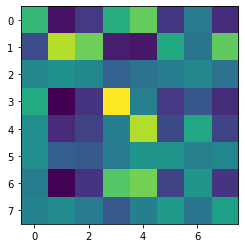

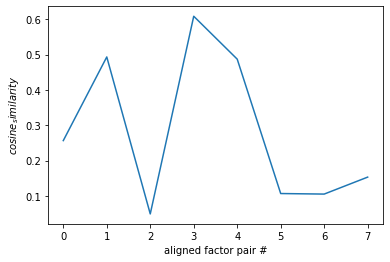

In [218]:
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
### correlate neural factors with behavioral factors

## first align the two sets of factors

# start with a cross-covariance matrix

method = 'cosine_similarity'

# vector_set1 = copy.deepcopy(fac_temp_toUse)
vector_set1 = copy.deepcopy(zscore(fac_temp_toUse,axis=0))
vector_set2 = copy.deepcopy(zscore(temporalFactors_s2pInd,axis=0))

xcorr_avg , xcorr_matched , xind1 , xind2  =  similarity_2(vector_set1  ,  vector_set2 , method)

sim_mat_aligned = pairwise_similarity(vector_set1[:,xind1] , vector_set2[:,xind2] , method)
aligned_diag = np.diag(sim_mat_aligned)
plt.figure()
plt.imshow(sim_mat_aligned)
plt.colorbar

plt.figure()
plt.plot(xcorr_matched)
plt.ylabel(f'${method}$')
plt.xlabel('aligned factor pair #')

<IPython.core.display.Javascript object>


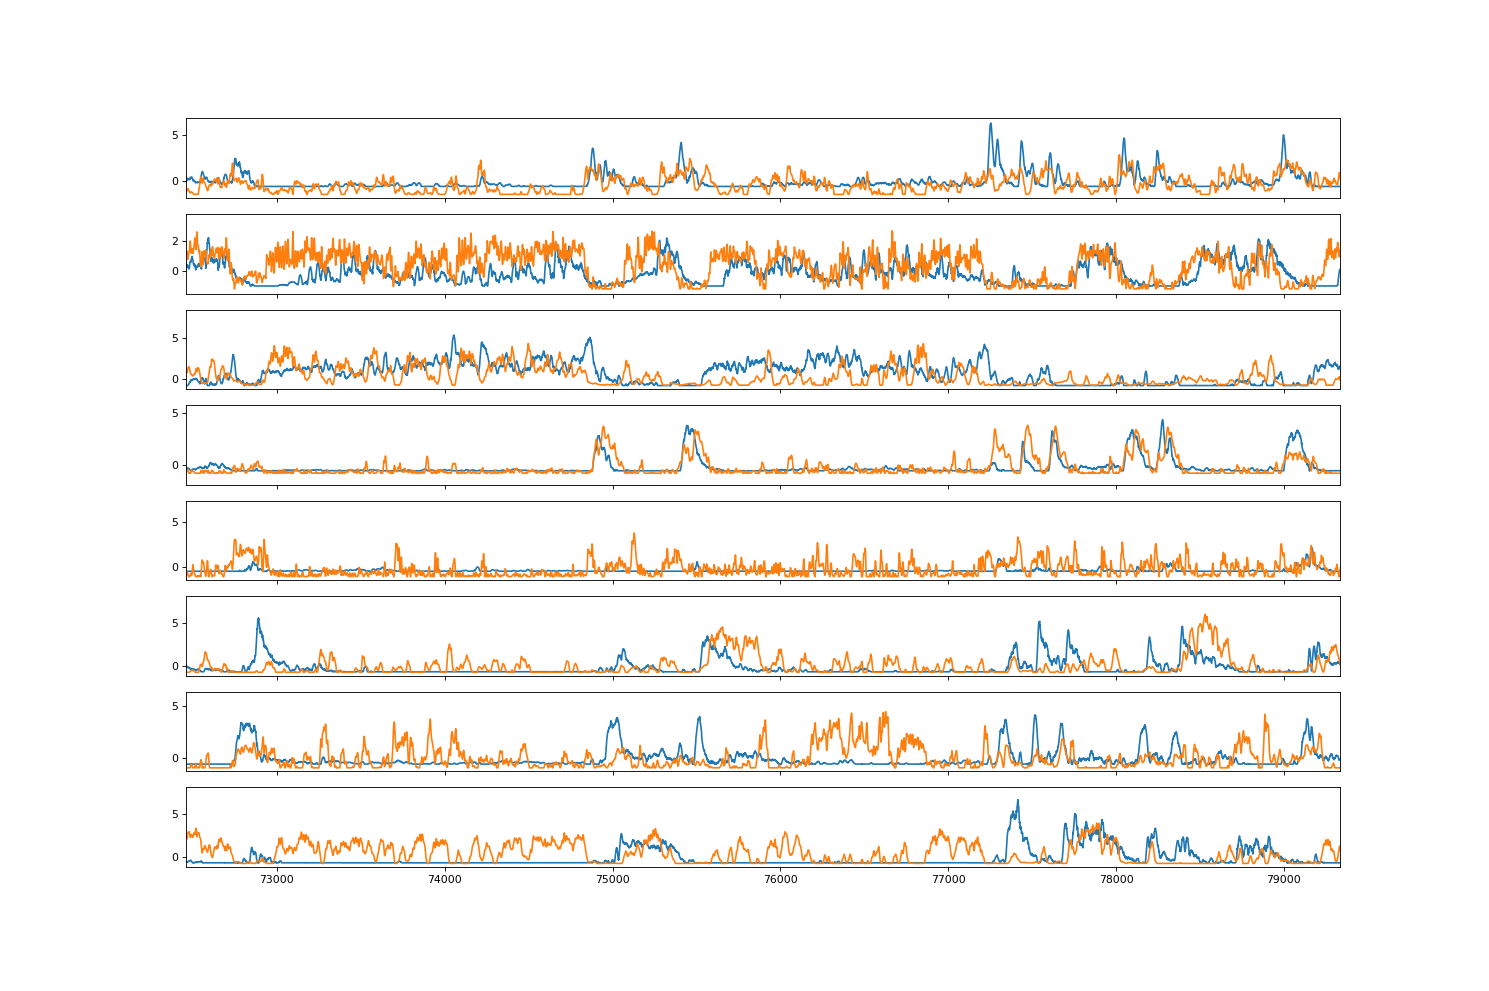

In [224]:
%matplotlib notebook

fig , axs = plt.subplots(vector_set1.shape[1] , sharex=True)
for ii in range(len(axs)):
    axs[ii].plot(vector_set1[:,xind1[ii]])
    axs[ii].plot(vector_set2[:,xind2[ii]])

In [107]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

cca = CCA(n_components=vector_set2.shape[1])
X_cc, Y_cc = cca.fit_transform(vector_set1, vector_set2)

In [108]:
pca = PCA(n_components=vector_set2.shape[1])
X_pc = pca.fit_transform(vector_set1)
X_pc_scree = pca.explained_variance_ratio_
Y_pc = pca.fit_transform(vector_set2)
Y_pc_scree = pca.explained_variance_ratio_

In [109]:
xcorr_mat_aligned = make_xcorrMat(X_cc , Y_cc)
R2_aligned_diag = np.diag(xcorr_mat_aligned)**2

Text(0.5, 0, 'component number')

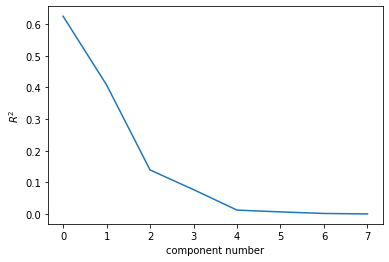

In [111]:
plt.figure()
plt.plot(R2_aligned_diag)
# plt.plot(X_pc_scree)
# plt.plot(Y_pc_scree)
plt.ylabel('$R^2$')
plt.xlabel('component number')

In [66]:
np.corrcoef(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3) , -scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))[0,1]**2

5.952432863288455e-05

<IPython.core.display.Javascript object>


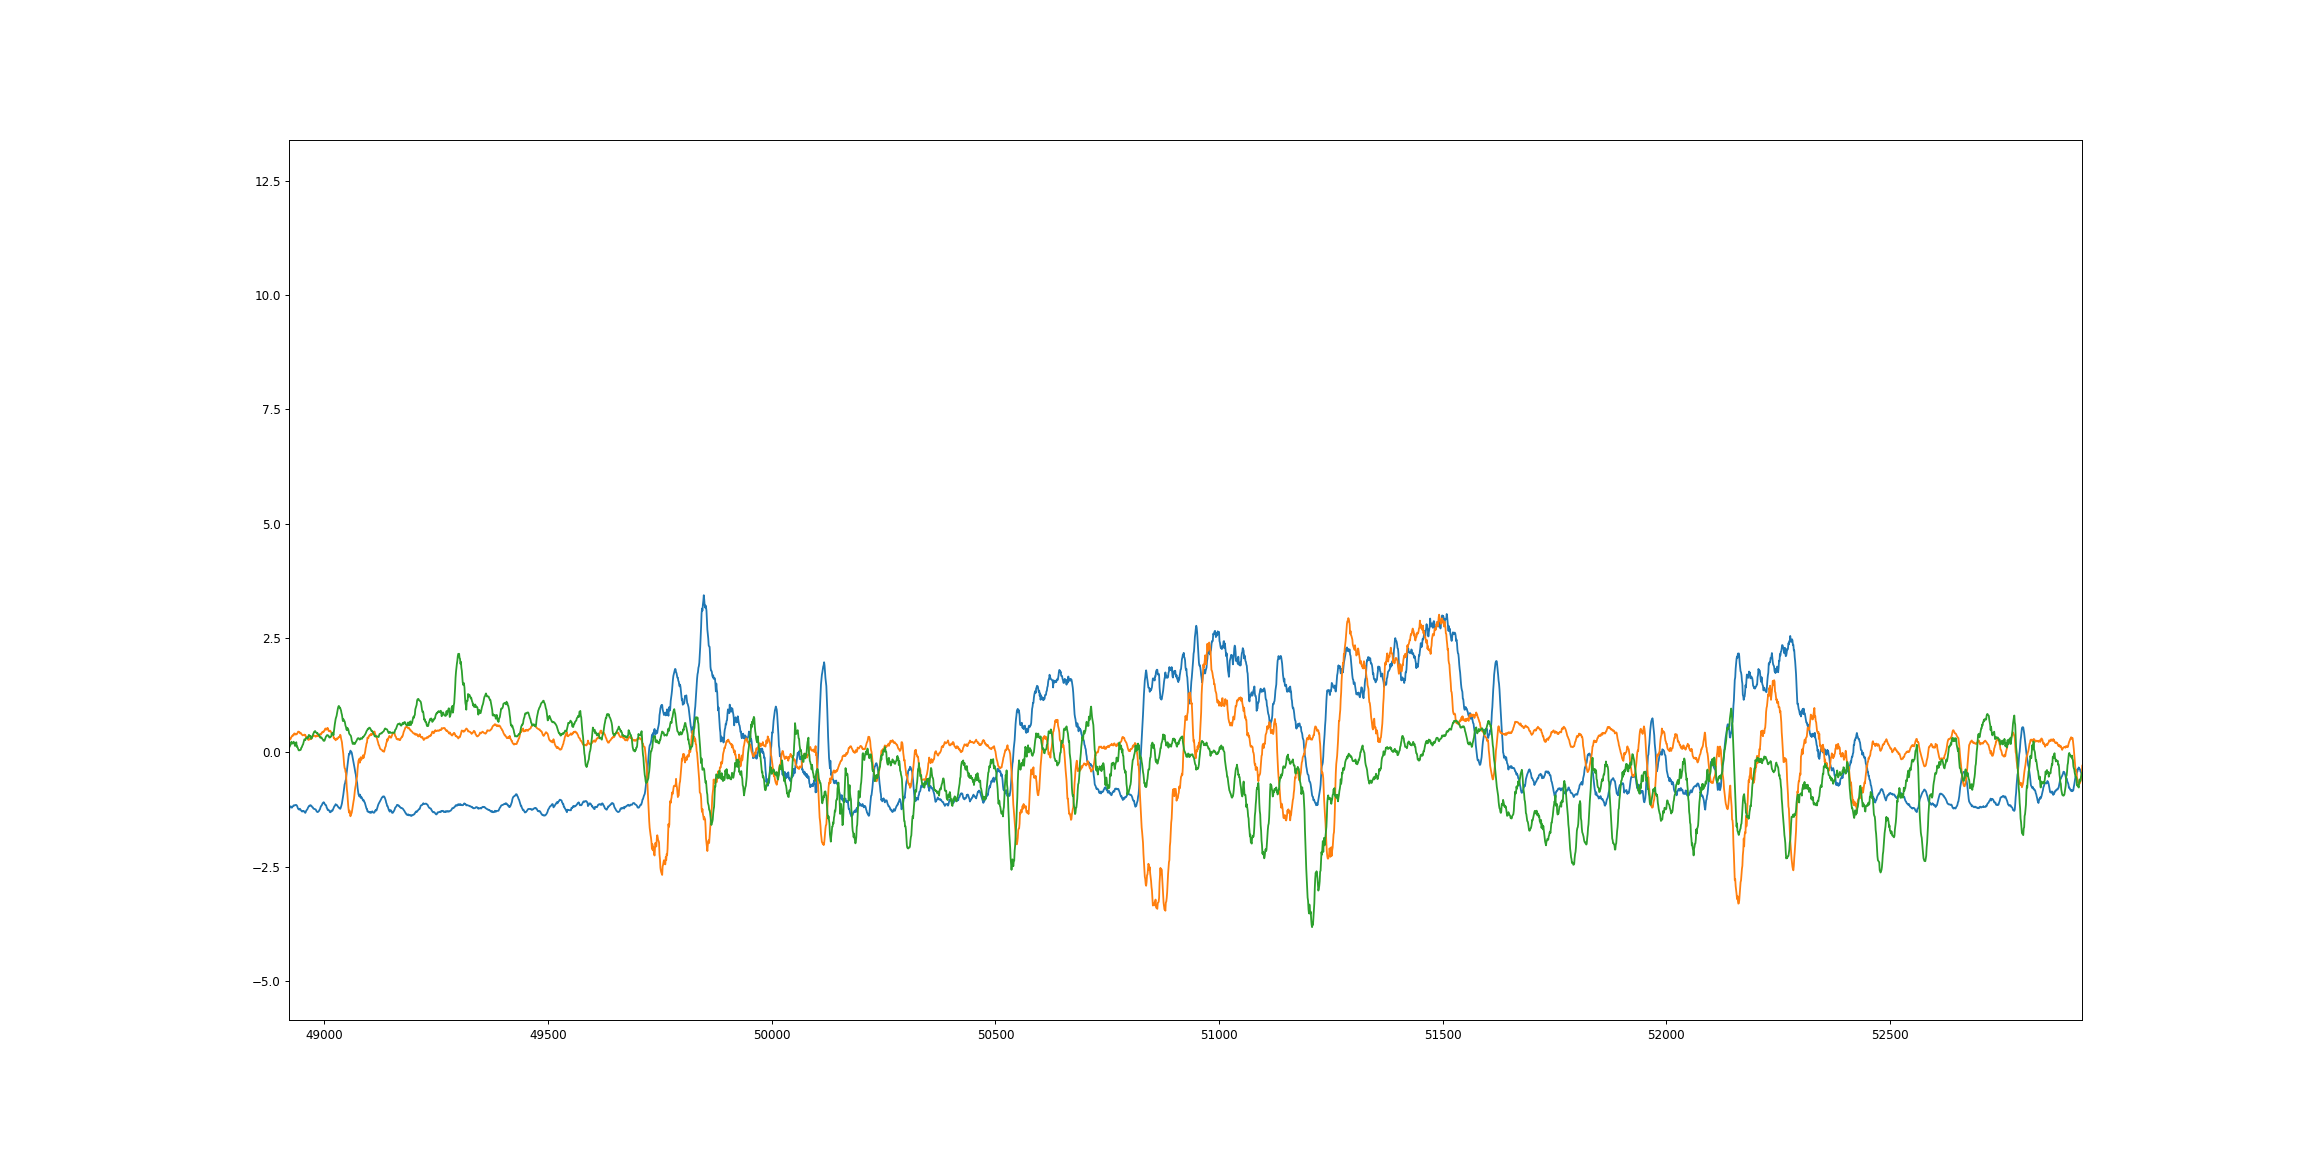

In [86]:
%matplotlib notebook
plt.figure()
plt.plot(X_cc[:,:3])
# plt.plot(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3))
# plt.plot(-scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))
# plt.plot(Y_c[:,0])
# plt.plot(-X_pc[:,1]/30)
# plt.plot(-Y_pc[:,0])


treadmill, train R: 0.8822762507831636
treadmill, test  R: 0.8772212840377442
R^2: 0.7695171811688287


<IPython.core.display.Javascript object>


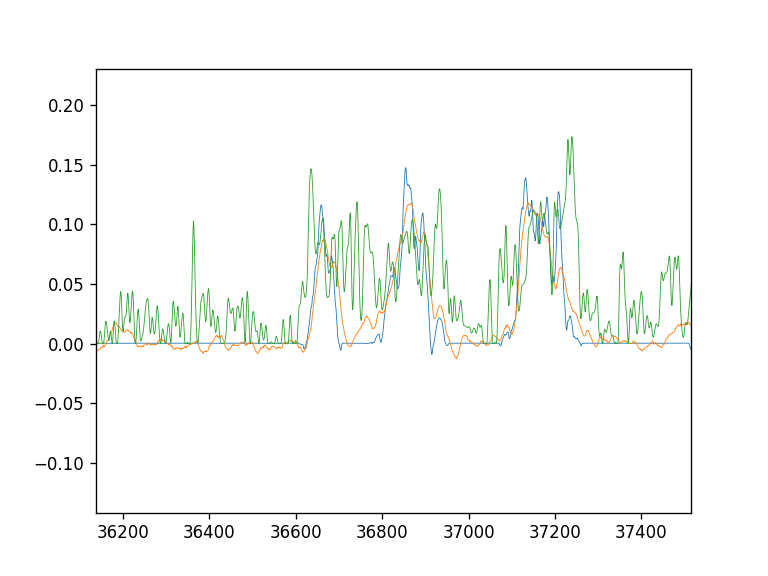

In [61]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,7]/10 , linewidth = 0.5)

treadmill, train R: 0.8471622646934773
treadmill, test  R: 0.8401484750669375


<IPython.core.display.Javascript object>


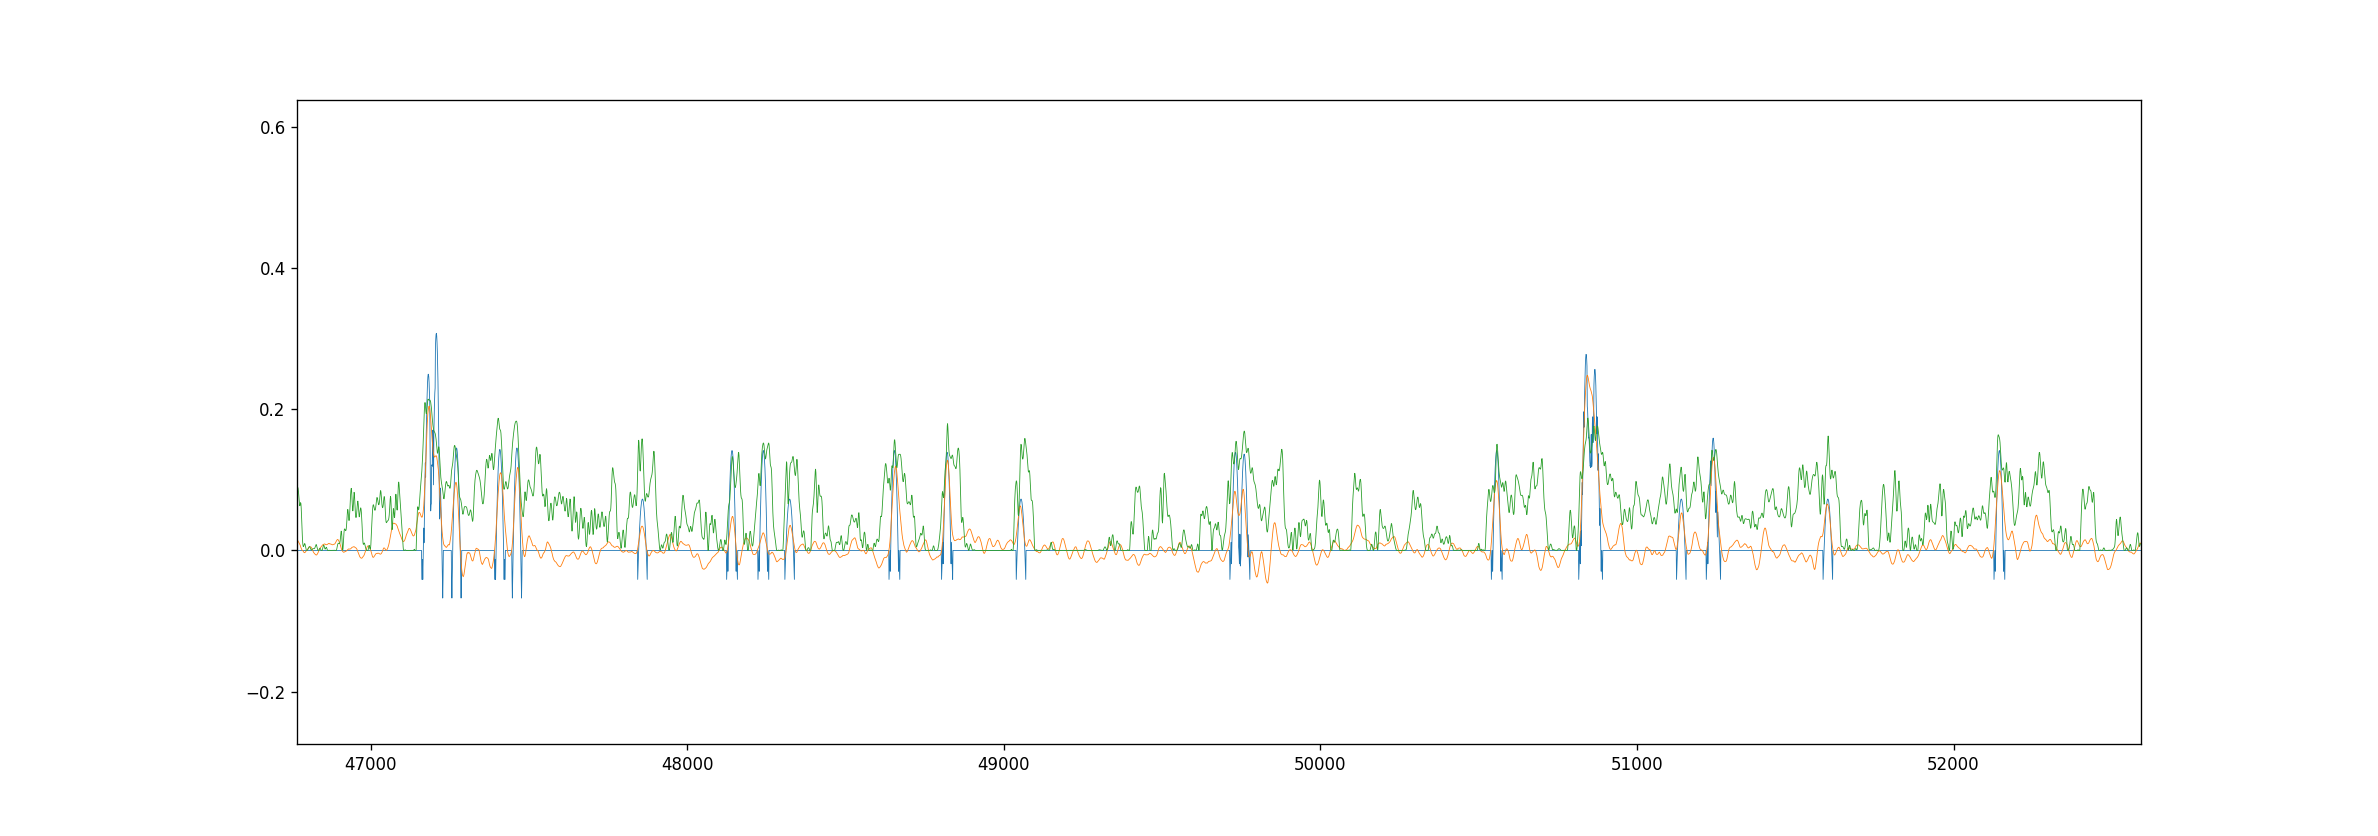

In [37]:
## Correlate to licking signal
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = spks[IsCell_ROIClassifier==True,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,2]/10 , linewidth = 0.5)

In [39]:
theta_FF.shape
F_zscore_roll[:,IsCell_ROIClassifier==True].shape

(108000, 1005)

In [40]:
np.sum(IsCell_ROIClassifier)

1005

In [62]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 8

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


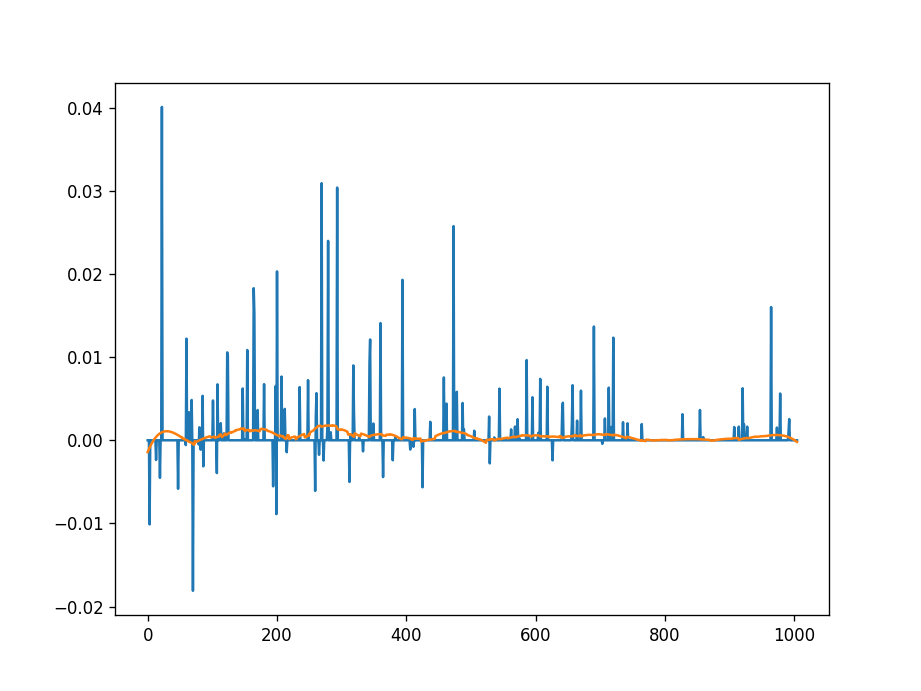

In [63]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3));